<a href="https://colab.research.google.com/github/supreetsandhu/Education-Inequality/blob/main/DATA_3320_Education_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

##### $\rightarrow$ This notebook will explore the ACT scores and different socioeconomic factors. We will do an analysis on these factors to see how they can effect and be related to the ACT score. We will create a prediction model based off the socioeconomic factors to see if we can predict an ACT score. 

In our additional step, we will examine how political parties of the different states in the educational data set are related to the average act of those states.

## Import libraries

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
from matplotlib import cm

from itertools import combinations
from math import comb

from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [168]:
df =pd.read_csv('https://raw.githubusercontent.com/supreetsandhu/Education-Inequality/main/clean_education_inequality_data_prep%20(1).csv')

In [169]:
df = df.dropna()

##### $\rightarrow$ Review the contents of the data set.

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7187 entries, 0 to 7226
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7187 non-null   int64  
 1   rate_unemployment  7187 non-null   float64
 2   percent_college    7187 non-null   float64
 3   percent_married    7187 non-null   float64
 4   median_income      7187 non-null   float64
 5   average_act        7187 non-null   float64
 6   percent_lunch      7187 non-null   float64
 7   year               7187 non-null   object 
 8   state              7187 non-null   object 
 9   zip_code           7187 non-null   int64  
 10  school_type        7187 non-null   object 
 11  school_level       7187 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 729.9+ KB


## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ List your questions about the data that will help you solve the problem.

-Are there correlations between the rate_unemployment,	percent_college,	percent_married,	median_income,	average_act, and	percent_lunch to one's ACT peformance?

## Analysis

We are first going to explore the relationship of the different socioeconomic factors.

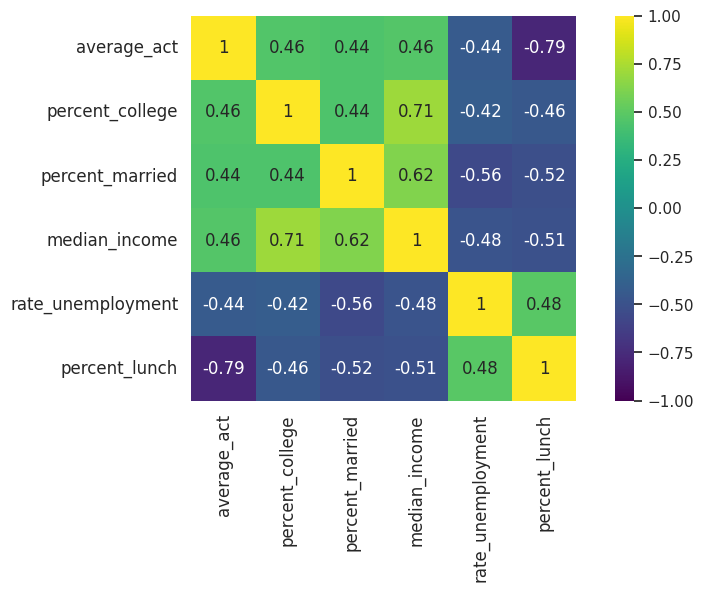

In [171]:
corr_matrix = df.loc[:,['average_act','percent_college', 'percent_married', 'median_income', 'rate_unemployment', 'percent_lunch']].corr()

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

This graphic tells us a bit about how the different factors are correlated to each other. This is helpful in getting an overall picture of the different socioeconomic factors we will be working with, but does not tell us a lot about how these factors are related to predicting an ACT score.

## Best Subset Selection

We are going to define our predictor and response variable as x and y respectifully. We are going to use all the possible predictor variables. The goal of this subselect to determine what factors we will use in our final model to predict an ACT score from socioeconomic factors.

In [172]:
X = df[['percent_college', 'percent_married', 'median_income', 'rate_unemployment', 'percent_lunch']]
y = df['average_act']

We are going to create a function to do best subset selection based on AIC, BIC, and adjusted  R2 . We are going to first define this function and we will input all our possible predicting variables to determine what the AIC, BIC and R2 values are and then use that to determine what factors to use in our final model.

In [173]:
def best_subset_selection(X, y):
    """ This function returns AIC, BIC, and adjusted R-squared values for use in best subset selection.

    Inputs
    ------
    X : array-like, shape (n_samples, n_features)
        Predictor values

    y : array-like, shape (n_samples, )
        Target values

    Returns
    ------
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors
   
    """

    variable_names = X.columns.values

    number_variables = len(variable_names)

    # Initialize empty arrays to hold the AIC, BIC, and adjusted r-squared for the best model 
    # at each number of predictors
    best_aic = np.zeros(number_variables)
    best_bic = np.zeros(number_variables)
    best_adjusted_rsquared = np.zeros(number_variables)

    # Initialize empty list to hold the names of the best predictors at each number of predictors
    best_predictors = list()

    # Loop over possible numbers of predictors
    for k in range(number_variables):

        # Get the names of all combinations of k+1 predictors
        subset_names = list(combinations(variable_names, k+1))

        # Loop over all models with k+1 predictors
        for n, predictor_names in enumerate(subset_names):

            # Fit the model
            predictors_subset = X.loc[:, predictor_names]

            model = sm.OLS(y, sm.add_constant(predictors_subset)).fit() 

            # Initialize the best values with the first model
            if n == 0:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

            # If a model has a better r-squared, update the best values
            elif model.rsquared > best_rsquared_k:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

        # Record the values for the best model at this number of predictors
        best_bic[k] = best_bic_k
        best_aic[k] = best_aic_k
        best_adjusted_rsquared[k] = best_adjusted_rsquared_k
        best_predictors.append(best_predictors_k)

    return best_aic, best_bic, best_adjusted_rsquared, best_predictors

The function will now be plotted in an easy to view visual.

In [174]:
def plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors):
    """ Plot the best AIC, BIC, and adjusted R-squared values at each number of possible predictors

    Input
    -----
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """

    number_predictors = np.arange(len(best_aic))+1

    plt.subplots(1,3, figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(number_predictors, best_aic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_aic)], np.min(best_aic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('AIC', fontsize=18)
    plt.title(best_predictors[np.argmin(best_aic)])
  

    plt.subplot(1,3,2)
    plt.plot(number_predictors, best_bic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_bic)], np.min(best_bic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('BIC', fontsize=18)
    plt.title(best_predictors[np.argmin(best_bic)])
  
    plt.subplot(1,3,3)
    plt.plot(number_predictors, best_adjusted_rsquared, 'b-o');
    plt.plot(number_predictors[np.argmax(best_adjusted_rsquared)], np.max(best_adjusted_rsquared), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('Adjusted R-squared', fontsize=18)
    plt.title(best_predictors[np.argmax(best_adjusted_rsquared)])


    plt.subplots_adjust(wspace = 0.3)
     

We are going to define our relsults into the the three seperate graphs.

In [175]:
best_aic, best_bic, best_adjusted_rsquared, best_predictors = best_subset_selection(X, y)

We will plot the results of the different AIC, BIC and R2 models.

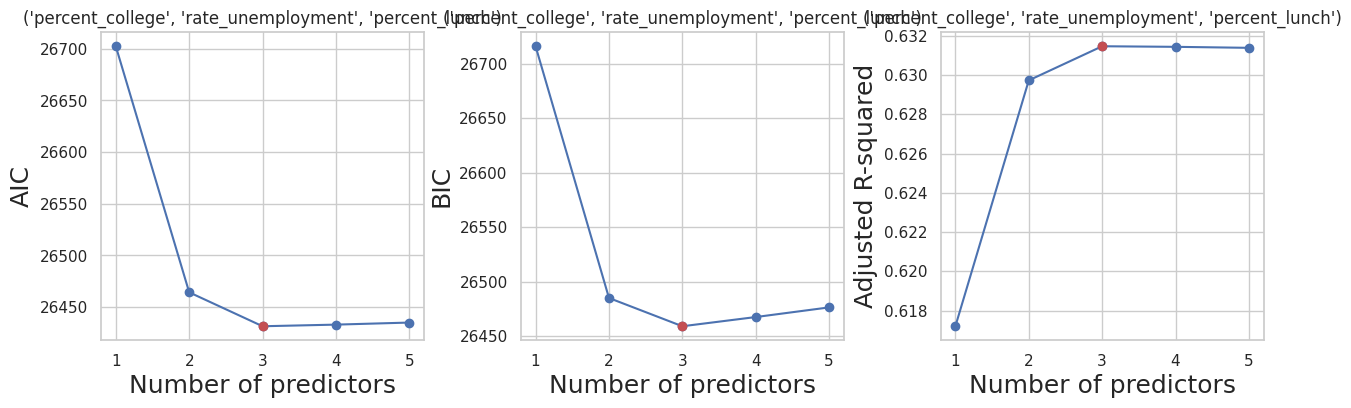

In [176]:
plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors)

The results show us that in all three models, the AIC, BIC and R2 model shows that three predictors are the best amount of variables to have. The three varaibles are stored in the following best_predictors variable.

In [177]:
best_predictors

[('percent_lunch',),
 ('percent_college', 'percent_lunch'),
 ('percent_college', 'rate_unemployment', 'percent_lunch'),
 ('percent_college', 'percent_married', 'rate_unemployment', 'percent_lunch'),
 ('percent_college',
  'percent_married',
  'median_income',
  'rate_unemployment',
  'percent_lunch')]

We will use the following predictors to calculate our average ACT prediction model, which are percent college, rate of unemployment and the percent lunch varaibles.

## Prediction Model

The next step will be formulating our model to predict the average act based on the following three factors: rate of unemployment, percent college and the percent lunch.

In [178]:
model = smf.ols(formula='average_act ~ percent_college + percent_lunch + rate_unemployment' , data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     4105.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        22:47:09   Log-Likelihood:                -13212.
No. Observations:                7187   AIC:                         2.643e+04
Df Residuals:                    7183   BIC:                         2.646e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6352      0.10

This model summary tells us the R squared value is around 0.632 which shows that there is a somewhat decent correlation between the predictors and the average ACT. 

We are going to do a scaling transformation. Although a Scaling transformation is not required for multiple linear regression models. The transformation can still helps us to interpret the relative importance of each predictor based on the magnitude of the estimated coefficients.

We are going to calculate the z score for the percent college.

In [179]:
df['percent_college_z'] = (df['percent_college'] - np.mean(df['percent_college']))/np.std(df['percent_college'],ddof=1)

We are going to calculate the z score for the percent lunch.

In [180]:
df['percent_lunch_z'] = (df['percent_lunch'] - np.mean(df['percent_lunch']))/np.std(df['percent_lunch'],ddof=1)

We are going to calculate the z score of the rate of unemployment.

In [181]:
df['rate_unemployment_z'] = (df['rate_unemployment'] - np.mean(df['rate_unemployment']))/np.std(df['rate_unemployment'],ddof=1)

We are going to create a model based off the z score of the different predictors z value.

In [182]:
model_z = smf.ols(formula='average_act ~ percent_college_z + percent_lunch_z + rate_unemployment_z', data=df).fit()

We will examine the values of the scaled transformation of the z score values

In [183]:
print(model_z.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     4105.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        22:47:10   Log-Likelihood:                -13212.
No. Observations:                7187   AIC:                         2.643e+04
Df Residuals:                    7183   BIC:                         2.646e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              20.3001    

The r squared value is a 0.632 so that the model has a somewhat correlation to the z values of the predictors and the average act score.

We are going to further the model by using sklearn for preprocessing. We will define our input and output variables. The input variables are the predictors and the output varaible is the average act score.

In [184]:
X = df[['percent_college', 'percent_lunch', 'rate_unemployment']]
y = df['average_act']

We are going to scale the predictor variables.  For the validation set approach to work, we can not incorporate any knowledge of the validation set's properties into the model building process.

In [185]:
scaler = StandardScaler().fit(X)

We will check the mean of the scaler to ensure that the scaling is correct

In [186]:
print(scaler.mean_, scaler.scale_)

[0.57314534 0.41031543 0.09626356] [0.16490487 0.23439916 0.05613174]


The mean is on between 0-1 which means that our scaling was correct.

We will do the scaling for the z score and ensure that the mean and standard deviation looks good.

In [187]:
Z = scaler.transform(X)

In [188]:
print(np.mean(Z, axis = 0).round(3))
print(np.std(Z, axis = 0))

[-0.  0. -0.]
[1. 1. 1.]


The mean is 0 and the standard deviation is 1. This means that the transformed data is good and we are able ot use in the model.

We will fit the multiple linear regression model with the scaled input variables.

In [189]:
model_z2 = sm.OLS(y, sm.add_constant(Z)).fit() 

In [190]:
print(model_z2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     4105.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        22:47:10   Log-Likelihood:                -13212.
No. Observations:                7187   AIC:                         2.643e+04
Df Residuals:                    7183   BIC:                         2.646e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3001      0.018   1131.180      0.0

The model shows that the r squared value is 0.632 which means that the there is a somewhat good correlation between the predictors and the average act.

In [191]:
model = smf.ols(formula='average_act ~ percent_college + percent_lunch + rate_unemployment', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     4105.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        22:47:10   Log-Likelihood:                -13212.
No. Observations:                7187   AIC:                         2.643e+04
Df Residuals:                    7183   BIC:                         2.646e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6352      0.10

The model of the three predictors of percent lunch, percent college, and rate of unemployment are now verified to work in our prediction model of the average act. we can see that the r squared value of this model is 0.632 which is a decent r squared value to be able to predict scores.

We are going to make our prediction model. We first will define out y prediction from the model that we created based off the three predictor variables.

In [192]:
y_prediction = model.predict()

We will now plot the average act and the predicted act score from our model. We can use this to compare how well our model compares to the actual variables.

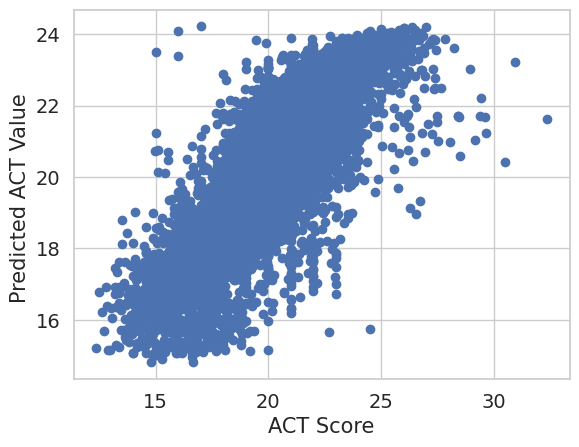

In [193]:
plt.plot(df['average_act'], y_prediction, 'o')

# Add axis labels
plt.xlabel('ACT Score', fontsize=15)
plt.ylabel('Predicted ACT Value ', fontsize=15)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

We can see that our average act predicts somewhat accurately compared to the actual act score. However, it is not perfect and there is some inconsistence with the predicted score and real values, but the values come somewhat close.

## Additional Step

For the additional step, we are going to include data about the states that are in the educational dataset and their political party that they were affliated with in the 2016 year USA presidential election

In [194]:
state_data =pd.read_csv('https://raw.githubusercontent.com/supreetsandhu/Education-Inequality/main/StateData.csv')

In [195]:
df1 =pd.read_csv('https://raw.githubusercontent.com/supreetsandhu/Education-Inequality/main/clean_education_inequality_data_prep%20(1).csv')

We are going to merge the data together into one data set to work with.

In [196]:
df3 = df1.merge(state_data, on='state', how='left')

In [197]:
import plotly.offline as po
import plotly.graph_objs as pg

Text(0, 0.5, 'Political Party ')

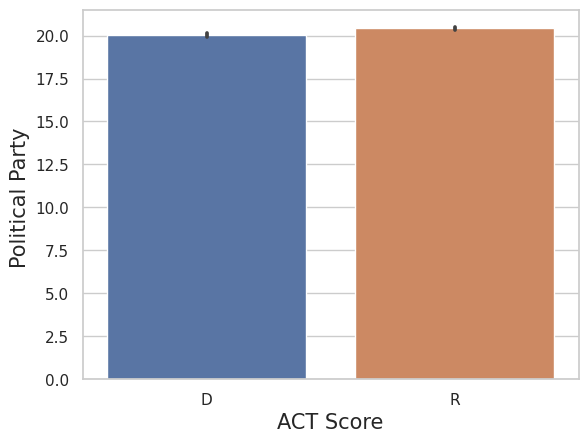

In [198]:

sns.barplot(data=df3, x='party', y='average_act')
plt.xlabel('ACT Score', fontsize=15)
plt.ylabel('Political Party ', fontsize=15)



This shows us that there is not a big difference between the democratic and repulician party states and the average act in those states. It is important to note that there is almost double the amount of data for republician states for democratic states.

We are now going to examine the average act score and our predictor factors that we used in our prediction model to see if there is a difference with the political parties.

We are going to look a percent lunch and the average act. We are going to seperate our points by color based off of their political party.

Text(0, 0.5, 'Perecent Free/Reduced Lunch ')

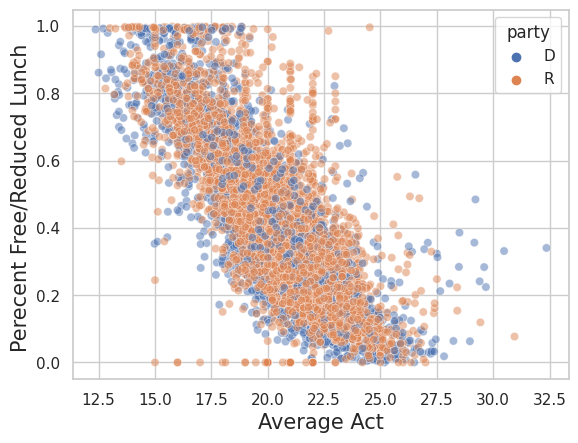

In [199]:
sns.scatterplot(data=df3, x='average_act', y='percent_lunch', hue = 'party', alpha = 0.5)
plt.xlabel('Average Act', fontsize=15)
plt.ylabel('Perecent Free/Reduced Lunch ', fontsize=15)


We can see that both political parties show a very similar trend. The points are stacked on top of each in a similar trend. This graph does not provide any correlation with the trend between  the average act and precent lunch between the two political parties.

We are going to look a rate of enemployment and the average act. We are going to seperate our points by color based off of their political party.

Text(0, 0.5, 'Rate of Unemployment ')

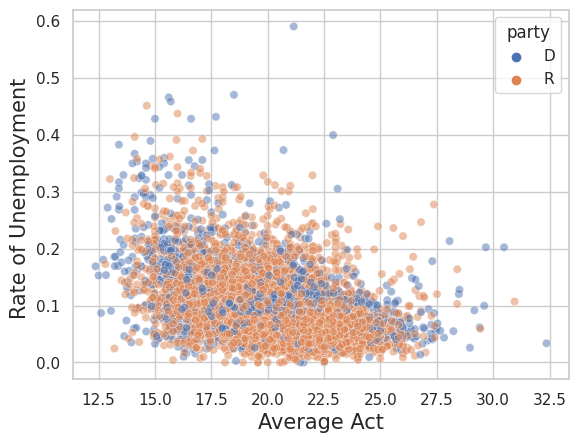

In [200]:
sns.scatterplot(data=df3, x='average_act', y='rate_unemployment', hue = 'party', alpha = 0.5)
plt.xlabel('Average Act', fontsize=15)
plt.ylabel('Rate of Unemployment ', fontsize=15)


The trend between the percent lunch and average act does not have a correlation between the there trend and political parties. There is no reasonable conclusion that we can draw from the Average Act adn percent lunch with the different political parties.

We are going to look a percent college and the average act. We are going to seperate our points by color based off of their political party.

Text(0, 0.5, 'Perecent College ')

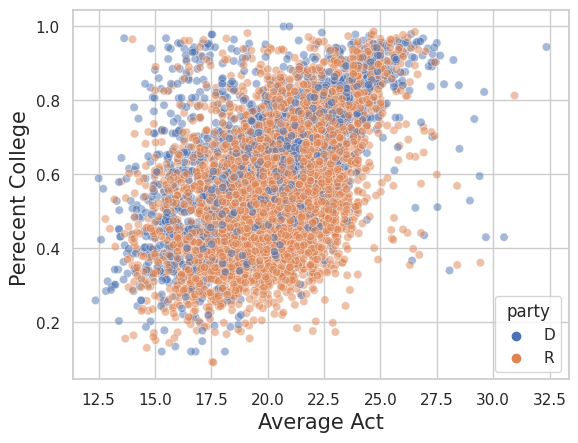

In [201]:
sns.scatterplot(data=df3, x='average_act', y='percent_college', hue = 'party', alpha = 0.5)
plt.xlabel('Average Act', fontsize=15)
plt.ylabel('Perecent College ', fontsize=15)


Lastly, we will examine the average act and the percent college. We can see that there is not a big correlation between between political parties and these two factors. There is no trend.

In our additional step, we examined the relationship between political party affliation of a state and the average act as well as the predictors we used for the average act model: rate of unemployment, percent lunch, and the percent of college. We found that there was no plausiable correlation that could be drawn from political party to these factors. 

There were limitations in the amount of data we had from states, we only were provided with 20 states and a large amount of the states were republician. This could lead to a bias in our data and lead to difficulties in providing a conclusion. 

## Conclusion

We are able to create a model that predicts the average act, we created this model from the following three variables: rate of unemployment, percent lunch, and the percent of college. The model that we created is somewhat close to the actual  variables, but we get a close estimate of what the average act score could be for a person from those three factors.

We also looked at political party affilation of the different states and we did not find a strong correlation between political party and the average act score.